# Trade Simulation
Models the Flow of Goods Around the World in Response to Central American Drift

In [38]:
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

## Data Preprocessing


In [39]:
trade_df = pd.read_csv("GTCDIT.csv")
trade_df.head()

,Destination_Label,Year,TransportMode_Label,Individual economies_Transport_expenditure_US_Value,Individual economies_Transport_expenditure_US_Footnote,Individual economies_Transport_expenditure_US_MissingValue,Individual economies_FOB_value_US_Value,Individual economies_FOB_value_US_Footnote,Individual economies_FOB_value_US_MissingValue,Individual economies_Kilograms_Value,...,Zambia_Kilograms_MissingValue,Zimbabwe_Transport_expenditure_US_Value,Zimbabwe_Transport_expenditure_US_Footnote,Zimbabwe_Transport_expenditure_US_MissingValue,Zimbabwe_FOB_value_US_Value,Zimbabwe_FOB_value_US_Footnote,Zimbabwe_FOB_value_US_MissingValue,Zimbabwe_Kilograms_Value,Zimbabwe_Kilograms_Footnote,Zimbabwe_Kilograms_MissingValue
0,Afghanistan,2018,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2018,Sea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2018,Railway,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2018,Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2019,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [40]:
# combine train and rode into a single mode called land
trade_df['TransportMode_Label'] = trade_df['TransportMode_Label'].replace({'Railway': 'Land', 'Road': 'Land'})

# delete columns whose names contain 'Footnote' or 'MissingValue'
cols_to_drop = [col for col in trade_df.columns if 'Footnote' in col or 'MissingValue' in col or 'Individual' in col]
trade_df.drop(columns=cols_to_drop, inplace=True)

# combine rows where Destination_Label, Year, and TransportMode_Label are the same, for numerical values if both NaN, leave NaN, otherwise sum Transport Expenditure, FOB value, and Kilograms
def custom_sum(series):
    if series.isna().all():
        return np.nan
    return series.sum(skipna=True)

# Define the key columns for grouping
key_columns = ['Destination_Label', 'Year', 'TransportMode_Label']

# Determine the numerical columns as all columns except the key columns.
numerical_columns = [col for col in trade_df.columns if col not in key_columns]


trade_df = trade_df.groupby(['Destination_Label', 'Year', 'TransportMode_Label'], as_index=False).agg(
    {col: custom_sum for col in numerical_columns}
)

trade_df.head()

,Destination_Label,Year,TransportMode_Label,Afghanistan_Transport_expenditure_US_Value,Afghanistan_FOB_value_US_Value,Afghanistan_Kilograms_Value,Albania_Transport_expenditure_US_Value,Albania_FOB_value_US_Value,Albania_Kilograms_Value,Algeria_Transport_expenditure_US_Value,...,Western Sahara_Kilograms_Value,Yemen_Transport_expenditure_US_Value,Yemen_FOB_value_US_Value,Yemen_Kilograms_Value,Zambia_Transport_expenditure_US_Value,Zambia_FOB_value_US_Value,Zambia_Kilograms_Value,Zimbabwe_Transport_expenditure_US_Value,Zimbabwe_FOB_value_US_Value,Zimbabwe_Kilograms_Value
0,Afghanistan,2018,Air,NaN,NaN,NaN,41.0,368.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,2018,Land,NaN,NaN,NaN,10.0,95.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,2018,Sea,NaN,NaN,NaN,8.0,18.0,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,2019,Air,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2843.0,6637.0,185.0,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,2019,Land,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,2915.0,154401.0,14786.0,NaN,NaN,NaN,NaN,NaN,NaN


In [41]:
# Extract unique destination countries from your trade data.
unique_countries = trade_df['Destination_Label'].unique()

# Load the Natural Earth Admin 0 shapefile.
world = gpd.read_file("natural_earth/ne_50m_admin_0_countries.shp")

# Filter the GeoDataFrame to include only the countries in your unique list.
countries_gdf = world[world['ADMIN'].isin(unique_countries)].copy()

# Compute the centroid of each country’s geometry.
countries_gdf['centroid'] = countries_gdf.geometry.centroid
countries_gdf['centroid_longitude'] = countries_gdf.centroid.x
countries_gdf['centroid_latitude'] = countries_gdf.centroid.y

# Drop all columns except for 'ADMIN', 'centroid_longitude', and 'centroid_latitude'.
countries_gdf = countries_gdf[['ADMIN', 'centroid_longitude', 'centroid_latitude']]

countries_gdf.head()

/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3630584222.py:11: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid'] = countries_gdf.geometry.centroid
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3630584222.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid_longitude'] = countries_gdf.centroid.x
/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/3630584222.py:13: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  countries_gdf['centroid_latitude'] = countries_gdf.centroid.y


,ADMIN,centroid_longitude,centroid_latitude
0,Zimbabwe,29.851441,-19.004204
1,Zambia,27.774759,-13.458242
2,Yemen,47.586762,15.909280
7,Uzbekistan,63.140015,41.755542
8,Uruguay,-56.018071,-32.799515


In [42]:
# Flatten the dataset so that each row is a single edge on the graph by extracting the values for columns corresponding to a particular origin
# Features: Edge_Id, Origin_Label (Extracted from the Columns, matches set of Destination_Labels/ADMIN), Destination_Label, Year, TransportMode, Route (Longitude and Latitude of Points Along Trade Route), Distance, Duration, Central_America (Boolean: Route Interects with Central America), FOB_value, Transport_expenditure, Kilograms

# Melt the dataframe so columns with origins become rows.
df_melted = trade_df.melt(
    id_vars=['Destination_Label', 'Year', 'TransportMode_Label'],
    var_name='origin_measure',
    value_name='value'
)

pattern = r'^([^_]+)_(Transport_expenditure|FOB_value|Kilograms).*'

def parse_col_name(col_name):
    match = re.match(pattern, col_name)
    if match:
        origin = match.group(1)    
        measure = match.group(2)  
        return origin, measure
    else:
        return None, None

df_melted[['Origin_Label', 'Measure']] = df_melted['origin_measure'].apply(
    lambda col_name: pd.Series(parse_col_name(col_name))
)

# Drop rows where we couldn't parse an origin & measure
df_melted.dropna(subset=['Origin_Label', 'Measure'], inplace=True)

# Pivot so we get separate columns for each measure type
df_flat = df_melted.pivot_table(
    index=['Origin_Label', 'Destination_Label', 'Year', 'TransportMode_Label'],
    columns='Measure',
    values='value',
    aggfunc='first'  
).reset_index()

# Rename columns
df_flat.rename(columns={
    'TransportMode_Label': 'TransportMode',
    'Transport_expenditure': 'Transport_expenditure',
    'FOB_value': 'FOB_value',
    'Kilograms': 'Kilograms'
}, inplace=True)


# Add placeholders for fields to populate later

#   Edge_Id, Origin_Label, Destination_Label, Year, TransportMode, 
#   Route (Longitude and Latitude of Points Along Trade Route), 
#   Distance, Duration, Central_America (Boolean), 
#   FOB_value, Transport_expenditure, Kilograms

df_flat['Edge_Id'] = range(1, len(df_flat) + 1)  # Create a simple numeric ID
df_flat['Route'] = None
df_flat['Distance'] = None
df_flat['Duration'] = None
df_flat['Central_America'] = None  # eventually store a Boolean

# Reorder columns into final format

df_edges = df_flat[
    [
        'Edge_Id',
        'Origin_Label',
        'Destination_Label',
        'Year',
        'TransportMode',
        'Route',
        'Distance',
        'Duration',
        'Central_America',
        'FOB_value',
        'Transport_expenditure',
        'Kilograms'
    ]
]

df_edges.head(10)

Measure,Edge_Id,Origin_Label,Destination_Label,Year,TransportMode,Route,Distance,Duration,Central_America,FOB_value,Transport_expenditure,Kilograms
0,1,Afghanistan,Africa,2018,Air,None,None,None,None,424719.0,86725.0,51077.0
1,2,Afghanistan,Africa,2018,Land,None,None,None,None,482720.0,91318.0,278137.0
2,3,Afghanistan,Africa,2018,Sea,None,None,None,None,684286.0,85248.0,432277.0
3,4,Afghanistan,Africa,2019,Air,None,None,None,None,283580.0,284644.0,145952.0
4,5,Afghanistan,Africa,2019,Land,None,None,None,None,1682224.0,139351.0,2050593.0
5,6,Afghanistan,Africa,2019,Sea,None,None,None,None,1712709.0,167652.0,2235132.0
6,7,Afghanistan,Africa,2020,Air,None,None,None,None,213627.0,177849.0,54278.0
7,8,Afghanistan,Africa,2020,Land,None,None,None,None,840181.0,106664.0,1191233.0
8,9,Afghanistan,Africa,2020,Sea,None,None,None,None,1131165.0,124661.0,1488327.0
9,10,Afghanistan,Africa,2021,Air,None,None,None,None,447401.0,251964.0,61058.0


## Route Computation

In [43]:
# As the crow flies 
def compute_air_route(long1, lat1, long2, lat2):
    return 0

# must go through water, route elgibility impacted by the drift of the Central American countries 
# perhaps have strategically placed nodes in waters around the world with no capacity constraint and compute the shortest path that does not intersect with a land mass 
# can ignore initial intersection with the 
def compute_sea_route():
    return 0

# similar computation to water transit but this time must be over land
def compute_land_route(): 
    return 0

## Replace Static Centroids for Central American Countries with Drifting Ones

In [44]:
# Load drift data
drift_df = pd.read_csv("drift_simulation_daily_positions.csv")

# Compute daily centroids for drifting countries
daily_centroids = (
    drift_df.groupby(['day', 'country'])[['longitude', 'latitude']]
    .mean()
    .reset_index()
    .rename(columns={'country': 'ADMIN'})
)

# Static centroids for non-drifting countries
static_centroids_base = countries_gdf[
    ~countries_gdf['ADMIN'].isin(daily_centroids['ADMIN'].unique())
][['ADMIN', 'centroid_longitude', 'centroid_latitude']].copy()

# Rename to match the dynamic drift data
static_centroids_base.rename(
    columns={'centroid_longitude': 'longitude', 'centroid_latitude': 'latitude'},
    inplace=True
)

# Cross join with days (0–1459)
all_days = pd.DataFrame({'day': range(1460)})
static_centroids_base['key'] = 1
all_days['key'] = 1

static_centroids = static_centroids_base.merge(all_days, on='key').drop(columns='key')
static_centroids = static_centroids[['day', 'ADMIN', 'longitude', 'latitude']]

# Combine drifting and static
all_centroids = pd.concat([daily_centroids, static_centroids], ignore_index=True)

# Create lookup dictionary: {day: {ADMIN: (lon, lat)}}
daily_centroid_dict = (
    all_centroids
    .groupby('day')
    .apply(lambda g: dict(zip(g['ADMIN'], zip(g['longitude'], g['latitude']))))
    .to_dict()
)


/var/folders/2f/7sxq51rj0xd8mgyvzzj2tgy80000gn/T/ipykernel_79157/401713720.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: dict(zip(g['ADMIN'], zip(g['longitude'], g['latitude']))))


In [45]:
from geopy.distance import geodesic
from shapely.geometry import LineString, Polygon

# Speeds in miles/day
speed_dict = {
    'Air': 500,
    'Land': 50,
    'Sea': 25
}

# Function to compute great-circle distance
def compute_distance(coord1, coord2):
    return geodesic(coord1[::-1], coord2[::-1]).miles  # reverse to lat/lon

# Placeholder: for now, simple heuristic for CA interaction
def intersects_central_america(line, ca_polygons):
    return any(poly.intersects(line) for poly in ca_polygons)


## Route Computation

Building sea routing graph...
Building land routing graph...
Sea route distance (Guatemala to Panama): None
Land route distance (Guatemala to Panama): None


AttributeError: 'MultiPolygon' object has no attribute 'exterior'

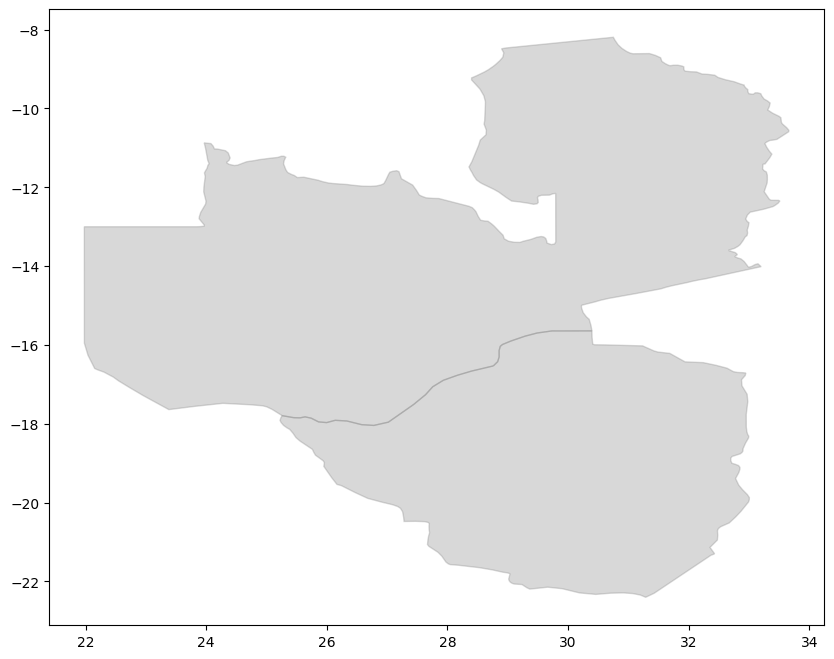

In [ ]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, box
from shapely.strtree import STRtree
from numba import njit
from math import radians, sin, cos, sqrt, atan2

# -----------------------------------------
# 1. Define fast haversine distance function
@njit
def haversine(lon1, lat1, lon2, lat2):
    R = 3958.8  # Earth radius in miles
    dlon = radians(lon2 - lon1)
    dlat = radians(lat2 - lat1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# -----------------------------------------
# 2. Load world land data (use your Natural Earth shapefile)
#    This "world" GeoDataFrame is already loaded in your notebook as "world" 
#    and later filtered to "countries_gdf", so we reuse that geometry.
#    (Make sure the CRS is set appropriately; here we simply use the geometry.)

land_polygons = list(world['geometry'])  # all country polygons from Natural Earth
# Build an STRtree for speed in intersection queries
land_tree = STRtree(land_polygons)

# -----------------------------------------
# 3. Generate a global grid of candidate waypoints.
def generate_grid(min_lon, max_lon, min_lat, max_lat, num_lon, num_lat):
    lons = np.linspace(min_lon, max_lon, num_lon)
    lats = np.linspace(min_lat, max_lat, num_lat)
    points = [Point(lon, lat) for lon in lons for lat in lats]
    return points

# Choose a bounding box that roughly covers the inhabited world.
# (Adjust these numbers as needed.)
global_waypoints = generate_grid(-180, 180, -60, 80, 60, 40)

# -----------------------------------------
# 4. Filter candidate waypoints by land/water.

# Assumes 'land_polygons' is the list you used to build the STRtree.
def is_on_land(point, land_tree):
    for idx in land_tree.query(point):
        poly = land_polygons[idx]
        if poly.contains(point):
            return True
    return False

water_points = [pt for pt in global_waypoints if not is_on_land(pt, land_tree)]
land_points = [pt for pt in global_waypoints if is_on_land(pt, land_tree)]

def build_routing_graph(nodes, land_tree, mode='sea', max_conn_dist=300):
    """
    Build a routing graph connecting nodes (list of Points) with edges only if
    the straight-line connection is "clear" for the given mode.
    
    Parameters:
      mode: 'sea' expects water nodes, and accepts an edge only if the connecting
            line does not intersect any land polygon.
            'land' expects land nodes and accepts an edge only if the entire line 
            is contained within at least one land polygon.
      max_conn_dist: maximum distance (in miles) for connections.
    """
    G = nx.Graph()
    coords = [(p.x, p.y) for p in nodes]
    n = len(coords)
    for i in range(n):
        for j in range(i + 1, n):
            a, b = coords[i], coords[j]
            d = haversine(a[0], a[1], b[0], b[1])
            if d > max_conn_dist:
                continue
            line = LineString([a, b])
            if mode == 'sea':
                # For sea routes, the line must not intersect any land polygon.
                # land_tree.query(line) returns indices; use those to look up polygons.
                if any(land_polygons[int(idx)].intersects(line) for idx in land_tree.query(line)):
                    continue
            elif mode == 'land':
                # For land routes, the line must be completely inside at least one polygon.
                if not any(land_polygons[int(idx)].contains(line) for idx in land_tree.query(line)):
                    continue
            G.add_edge(a, b, weight=d)
    return G


# Build our two routing graphs.
print("Building sea routing graph...")
sea_graph = build_routing_graph(water_points, land_tree, mode='sea', max_conn_dist=300)
print("Building land routing graph...")
land_graph = build_routing_graph(land_points, land_tree, mode='land', max_conn_dist=150)

# -----------------------------------------
# 6. Define helper functions for shortest path routing.

def closest_node(coord, nodes):
    """Find the node in 'nodes' (list of (lon, lat)) closest to the given coord."""
    return min(nodes, key=lambda pt: haversine(coord[0], coord[1], pt[0], pt[1]))

def compute_sea_route(source_coord, target_coord):
    """
    Given source and target coordinates (tuples of (lon, lat)),
    find the closest sea nodes in the sea_graph, then compute the 
    shortest path distance and route.
    Returns (total_distance, route) where route is a list of coordinates.
    """
    sea_nodes = list(sea_graph.nodes)
    source_node = closest_node(source_coord, sea_nodes)
    target_node = closest_node(target_coord, sea_nodes)
    try:
        path = nx.shortest_path(sea_graph, source=source_node, target=target_node, weight='weight')
        total_distance = 0
        for i in range(len(path)-1):
            total_distance += haversine(path[i][0], path[i][1], path[i+1][0], path[i+1][1])
        return total_distance, path
    except nx.NetworkXNoPath:
        return None, None

def compute_land_route(source_coord, target_coord):
    """
    Similar to compute_sea_route, but uses the land_graph.
    """
    land_nodes = list(land_graph.nodes)
    source_node = closest_node(source_coord, land_nodes)
    target_node = closest_node(target_coord, land_nodes)
    try:
        path = nx.shortest_path(land_graph, source=source_node, target=target_node, weight='weight')
        total_distance = 0
        for i in range(len(path)-1):
            total_distance += haversine(path[i][0], path[i][1], path[i+1][0], path[i+1][1])
        return total_distance, path
    except nx.NetworkXNoPath:
        return None, None

# -----------------------------------------
# 7. Example usage: Compute a sea route between Guatemala and Panama.
# Note: These coordinates are from your drifting centroids (for day 729).
guatemala_coord = daily_centroid_dict[729]['Guatemala']
panama_coord = daily_centroid_dict[729]['Panama']

sea_distance, sea_route = compute_sea_route(guatemala_coord, panama_coord)
print("Sea route distance (Guatemala to Panama):", sea_distance)

land_distance, land_route = compute_land_route(guatemala_coord, panama_coord)
print("Land route distance (Guatemala to Panama):", land_distance)

# -----------------------------------------
# 8. Visualization of the sea route (as an example)
fig, ax = plt.subplots(figsize=(10, 8))

# Plot land polygons from Natural Earth
for poly in land_polygons:
    if poly.geom_type == 'Polygon':
        xs, ys = poly.exterior.xy
        ax.fill(xs, ys, color='gray', alpha=0.3)
    elif poly.geom_type == 'MultiPolygon':
        for part in poly.geoms:
            xs, ys = part.exterior.xy
            ax.fill(xs, ys, color='gray', alpha=0.3)


# Plot sea graph nodes (water points)
sea_coords = np.array([pt for pt in sea_graph.nodes])
ax.scatter(sea_coords[:,0], sea_coords[:,1], s=5, color='blue', alpha=0.3)

# Plot the computed sea route if available
if sea_route is not None:
    route_xs, route_ys = zip(*sea_route)
    ax.plot(route_xs, route_ys, color='blue', linewidth=2, label=f"Sea Route ({sea_distance:.1f} mi)")

# Plot country centroids for Guatemala and Panama
ax.scatter(*guatemala_coord, color='red', label='Guatemala')
ax.scatter(*panama_coord, color='green', label='Panama')

ax.set_title("Dense Sea Routing Graph and Computed Route\n(Example: Guatemala to Panama on Day 729)")
ax.legend()
ax.axis("equal")
plt.show()


## Daily Modality Assignment

Each day, we choose the cheapest transport mode (Air, Land, or Sea) for every trade route.

The cost for a mode is calculated as:

C = alpha * distance + beta * (distance / speed) + gamma

If the mode is different from the previous day, we add a switching penalty of 20%.

We check all available modes for each route and select the one with the lowest total cost. The result is stored in a dictionary like this:

daily_edge_modes[day][(origin, dest)] = best_mode


In [ ]:
cost_params = {
    'Air':  {'alpha': 0.20, 'beta': 0.05, 'gamma': 200},
    'Sea':  {'alpha': 0.04, 'beta': 0.02, 'gamma': 50},
    'Land': {'alpha': 0.08, 'beta': 0.03, 'gamma': 100},
}
switch_penalty = 0.20  # 20% of today’s cost if changing mode

daily_edge_modes = {}  # {day: {(origin, dest): chosen_mode}}

for day in tqdm(days_to_simulate):
    daily_edge_modes[day] = {}

    edges_seen = set()

    for mode in ['Air', 'Land', 'Sea']:
        G = graphs_by_day[mode].get(day, None)
        if G is None:
            continue

        for u, v, data in G.edges(data=True):
            if (u, v) in edges_seen:
                continue  # already evaluated this edge for another mode
            edges_seen.add((u, v))

            cost_by_mode = {}
            for m in ['Air', 'Land', 'Sea']:
                Gm = graphs_by_day[m].get(day)
                if Gm is None or not Gm.has_edge(u, v):
                    continue

                d = Gm[u][v]['distance']
                t = Gm[u][v]['duration']
                α, β, γ = cost_params[m]['alpha'], cost_params[m]['beta'], cost_params[m]['gamma']
                base_cost = α * d + β * t + γ

                # Check for switching penalty
                prev_mode = daily_edge_modes.get(day - 1, {}).get((u, v), None)
                if prev_mode is not None and prev_mode != m:
                    base_cost *= (1 + switch_penalty)

                cost_by_mode[m] = base_cost

            # Pick mode with min cost
            if cost_by_mode:
                best_mode = min(cost_by_mode, key=cost_by_mode.get)
                daily_edge_modes[day][(u, v)] = best_mode



100%|██████████| 292/292 [00:25<00:00, 11.43it/s]


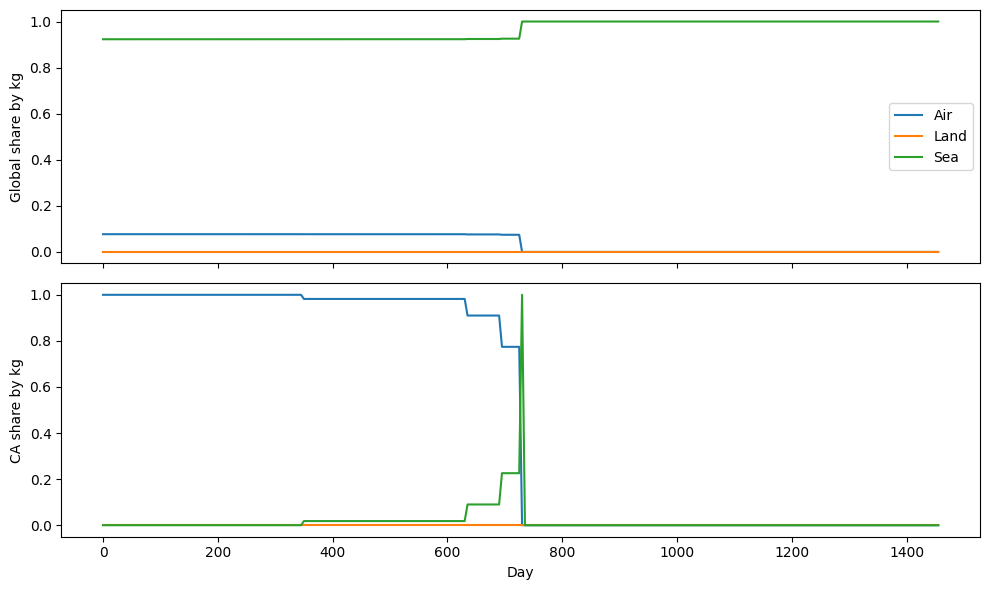

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict

# --- Central America set ---
ca_countries = {'Belize', 'Costa Rica', 'El Salvador', 'Guatemala', 'Honduras', 'Nicaragua', 'Panama'}

# --- Initialize ---
kg_by_mode = defaultdict(list)
kg_by_mode_ca = defaultdict(list)

for day in sorted(daily_edge_modes.keys()):
    mode_totals = defaultdict(float)
    mode_ca_totals = defaultdict(float)

    for (u, v), mode in daily_edge_modes[day].items():
        G = graphs_by_day[mode][day]
        if not G.has_edge(u, v):
            continue

        kg = G[u][v]['kilograms'] or 0
        mode_totals[mode] += kg
        if u in ca_countries or v in ca_countries:
            mode_ca_totals[mode] += kg

    total = sum(mode_totals.values())
    total_ca = sum(mode_ca_totals.values())

    for m in ['Air', 'Land', 'Sea']:
        kg_by_mode[m].append(mode_totals[m] / total if total > 0 else 0)
        kg_by_mode_ca[m].append(mode_ca_totals[m] / total_ca if total_ca > 0 else 0)

# --- Plot ---
days = sorted(daily_edge_modes.keys())

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Global trade
for m in ['Air', 'Land', 'Sea']:
    axs[0].plot(days, kg_by_mode[m], label=m)
axs[0].set_ylabel('Global share by kg')
axs[0].legend()

# Central America trade
for m in ['Air', 'Land', 'Sea']:
    axs[1].plot(days, kg_by_mode_ca[m], label=m)
axs[1].set_ylabel('CA share by kg')
axs[1].set_xlabel('Day')

plt.tight_layout()
plt.show()
